# 利用fbprophet预测新冠疫情期间的供水总量论文

**2020年3月1日prophet预测三月供水总量**

In [ ]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

In [ ]:

sup_water = pd.read_excel(r'C:/Users/Jay/mypyworks/自来水数据/2015-2020日供水总量.xlsx')

In [ ]:
sup_water

In [ ]:
#设置数据集
sup_water = sup_water.set_index('QUOTA_DATE').sort_index()['2015':]

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(311)
sup_water['水厂供水总量'].plot(title='水厂供水总量')
plt.subplot(312)
sup_water['最高温度'].plot(title='最高温度') 
plt.subplot(313)
sup_water['最低温度'].plot(title='最低温度')

In [ ]:
#判断缺失值
# sup_water[sup_water.isnull().any(axis=1)]

# np.isinf(sup_water['最高温度']).value_counts()

#判断数据框里面所有不是有限数据的数，可以排除null，np.nan,np.inf
sup_water[~(np.isfinite(sup_water).all(axis=1))]

In [ ]:
#判断离群值
# print(sup_water['最高温度'].value_counts(dropna=False))
am = sup_water['最高温度'].rolling(window=3,min_periods=0,center=True).mean()
diff = sup_water['最高温度'].values-am

# plt.figure(figsize=(12,8))
# plt.scatter(data = sup_water, x= sup_water.index.values,
#          y = '最低温度', 
#          marker='.',label='最低温度')
# plt.plot(sup_water.index.values,sup_water['上限'],'r--',label='离群上限')
# plt.plot(sup_water.index.values,sup_water['下限'],'r--',label='离群下限')
# plt.legend(loc='best')
# plt.title("动态判断时间序列的离群值")

sup_water.loc[diff.abs()>diff.std(ddof=0)*4,].sort_values('最高温度')

In [ ]:
sup_water.eval("平均温度=(最高温度+最低温度)/2",inplace=True)

In [ ]:
sup_water

**按照多项式处理来看各指标的相关性**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3,include_bias=1)
X_poly = poly_features.fit_transform(sup_water[['最低温度','最高温度','平均温度']])

#将poly数组转化程dataframe画相关矩阵，np也有相关矩阵函数，但带列名更加清楚。
sup_water_poly= pd.DataFrame(data=X_poly,columns=poly_features.get_feature_names())

sup_water_poly['水厂供水总量'] = sup_water['水厂供水总量'].values

sup_water_poly.corrwith(sup_water_poly['水厂供水总量']).sort_values(ascending=False)

**从上面结果来看最高温的相关性最高**

In [ ]:
#pd还提供做相关矩阵和相关性图的函数，但因为指标太多，因此省去。
# sup_water.corr()
# pd.plotting.scatter_matrix(sup_water,figsize=(12,8),alpha=0.2)

## **正式运用模型**

In [ ]:
sup_water_fp=sup_water.reset_index()[['QUOTA_DATE','水厂供水总量','最高温度']].rename(columns={'QUOTA_DATE':'ds','水厂供水总量':'y'})

In [ ]:
# sup_water_fp['y'] = np.log(sup_water_fp['y'])

In [ ]:
# cap = 5050000
# sup_water_fp['cap']= cap

In [ ]:
# import borax

In [ ]:
import sxtwl
lunar = sxtwl.Lunar()


In [ ]:
guoqing = pd.DataFrame({
  'holiday': 'guoqing',
  'ds': pd.date_range(start= '2015-10-1',periods=6,freq='AS-OCT'),
  'lower_window': 0,
  'upper_window': 6,
})

spring_date=[]
for i in list(range(2014,2020)):
    solar_day = lunar.getDayByLunar(i,12,30)
    solar_date = dt.date(solar_day.y, solar_day.m, solar_day.d)
    spring_date.append(solar_date)
    
spring = pd.DataFrame({
  'holiday': 'spring',
  'ds':spring_date,
  'lower_window': -14,
  'upper_window': 14,
})

covid1 = pd.DataFrame({
  'holiday': 'covid1',
  'ds':pd.date_range(start= '2020-1-23',end='2020-2-23'),
  'lower_window': 0,
  'upper_window': 0,
})

covid2 = pd.DataFrame({
  'holiday': 'covid2',
  'ds':pd.date_range(start= '2020-2-24',end='2020-4-30'),
  'lower_window': 0,
  'upper_window': 0,
})
holidays = pd.concat((guoqing, spring,covid1,covid2))

In [ ]:
holidays

In [ ]:
sup_water_fp

In [ ]:
#initial=三（10=-1），period=7天，cv=10折，horizon=31天
7*(10-1)+365*3+31+1
# dt.date(2020,4,2)-dt.timedelta(days = 31)

In [ ]:
sup_water_train = sup_water_fp[-1190:]
# sup_water_test = sup_water_fp[-31:]

In [ ]:
sup_water_train

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
# from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") 
def fun_rmse(df):
            return np.sqrt(np.mean(np.square(df['y']-df['yhat'])))
df1 = pd.DataFrame(columns=('param',  'rmse'))
i = 0
while i < 20:
    i+=1
    print('第{:d}次计算'.format(i))
    try:
        # 参数搜索
        changepoint_range = 0.8 
        changepoint_prior_scale = 0.05
        holidays_prior_scale = round(np.random.uniform(0.1,10.1),1)
        yearly_fourier_order = np.random.randint(1,11)
        weekly_prior_scale = round(np.random.uniform(0.1,10.1),1)
        yearly_prior_scale = round(np.random.uniform(0.1,10.1),1)
        regressor_prior_scale = round(np.random.uniform(0.1,10.1),1)
        param={'ch_range':changepoint_range,'ch_ps':changepoint_prior_scale,'holi_ps':holidays_prior_scale,
                      'weekly_ps':weekly_prior_scale,'yearly_forder':yearly_fourier_order,'yearly_ps':yearly_prior_scale,
                      'regressor_ps':regressor_prior_scale}
        m = Prophet(holidays=holidays,
            n_changepoints = 25,
            changepoint_range=changepoint_range,
            changepoint_prior_scale=changepoint_prior_scale,
            holidays_prior_scale=holidays_prior_scale)
        m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=weekly_prior_scale)
        m.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_fourier_order, prior_scale=yearly_prior_scale)
        m.add_regressor('最高温度',prior_scale=regressor_prior_scale)
        m.fit(sup_water_train)

        df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days') 
        rmse_ave = df_cv.groupby('cutoff').apply(fun_rmse).mean()
        df1.loc[i-1] = [param,rmse_ave]                  
    except:
        continue

In [49]:
df1.sort_values(['rmse']).head(10)    
df1.loc[10]['param']          

{'ch_range': 0.89,
 'ch_ps': 0.3,
 'holi_ps': 7.4,
 'weekly_ps': 4.8,
 'yearly_forder': 7,
 'yearly_ps': 2.6,
 'regressor_ps': 9.8}

In [50]:
m = Prophet(holidays=holidays,
            n_changepoints = 25,
            changepoint_range=0.90,
            changepoint_prior_scale=0.3,
#             yearly_seasonality=10,
#             seasonality_prior_scale=10,
            holidays_prior_scale=7.4)
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=5)
m.add_seasonality(name='yearly', period=365.25, fourier_order=7, prior_scale=2.6)
m.add_regressor('最高温度',prior_scale=10)
m.fit(sup_water_train)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# #交叉验证
# from fbprophet.diagnostics import cross_validation
# from sklearn.metrics import mean_squared_error
# df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days')
# # df_cv[['yhat','yhat_lower','yhat_upper','y']] = np.exp(df_cv[['yhat','yhat_lower','yhat_upper','y']])

# def rmse(df):
#     return np.sqrt(mean_squared_error(df['y'],df['yhat']))

# df_cv.groupby('cutoff').apply(rmse).mean()

In [ ]:
# help(Prophet)

In [51]:
m.changepoints_t

array([0.03616484, 0.07232969, 0.10765349, 0.14381833, 0.17998318,
       0.21614802, 0.25231287, 0.28763667, 0.32380151, 0.35996636,
       0.3961312 , 0.43229605, 0.46761985, 0.50378469, 0.53994954,
       0.57611438, 0.61227923, 0.64760303, 0.68376787, 0.71993272,
       0.75609756, 0.79226241, 0.82758621, 0.86375105, 0.8999159 ])

In [ ]:
# df_cv.query("cutoff ==  '2020-03-02'")

In [ ]:
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p

In [52]:
future = m.make_future_dataframe(periods=17)
future 

,ds
0,2016-12-30
1,2016-12-31
2,2017-01-01
3,2017-01-02
4,2017-01-03
...,...
1202,2020-04-15
1203,2020-04-16
1204,2020-04-17
1205,2020-04-18


In [54]:
# future['cap'] = cap
future['最高温度'] = np.r_[sup_water_train['最高温度'].values,
                       np.array([21,19,18,18,22,24,24,24,23,24,23,23,29,29,26,27,26])]

In [55]:
print(future)
forecast = m.predict(future)

             ds  最高温度
0    2016-12-30  19.0
1    2016-12-31  23.0
2    2017-01-01  24.0
3    2017-01-02  26.0
4    2017-01-03  27.0
...         ...   ...
1202 2020-04-15  29.0
1203 2020-04-16  29.0
1204 2020-04-17  26.0
1205 2020-04-18  27.0
1206 2020-04-19  26.0

[1207 rows x 2 columns]


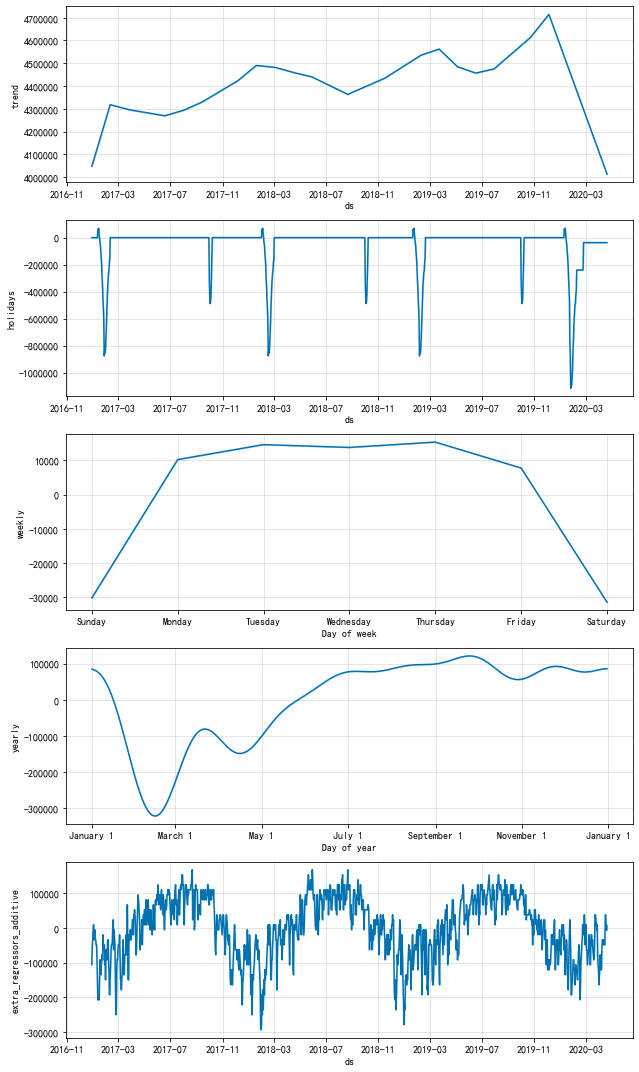

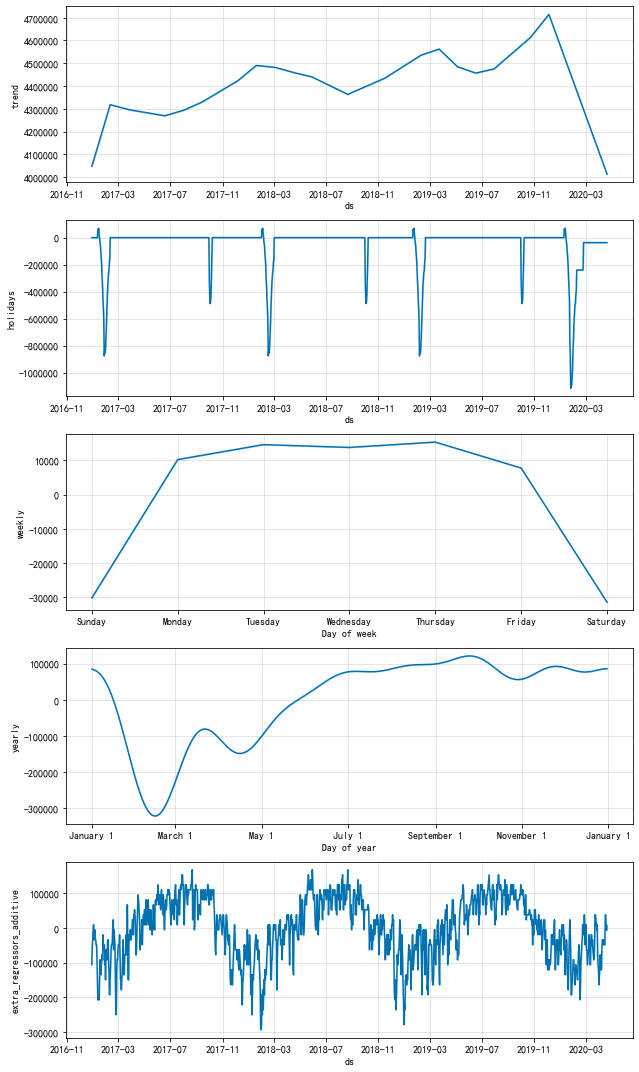

In [56]:
m.plot_components(forecast)

In [57]:
forecast.tail(20)[['ds','yhat']]

,ds,yhat
1187,2020-03-31,3.821137e+06
1188,2020-04-01,3.839704e+06
1189,2020-04-02,3.846239e+06
1190,2020-04-03,3.872312e+06
1191,2020-04-04,3.795077e+06
1192,2020-04-05,3.772795e+06
1193,2020-04-06,3.804240e+06
1194,2020-04-07,3.857198e+06
1195,2020-04-08,3.876560e+06
1196,2020-04-09,3.869945e+06


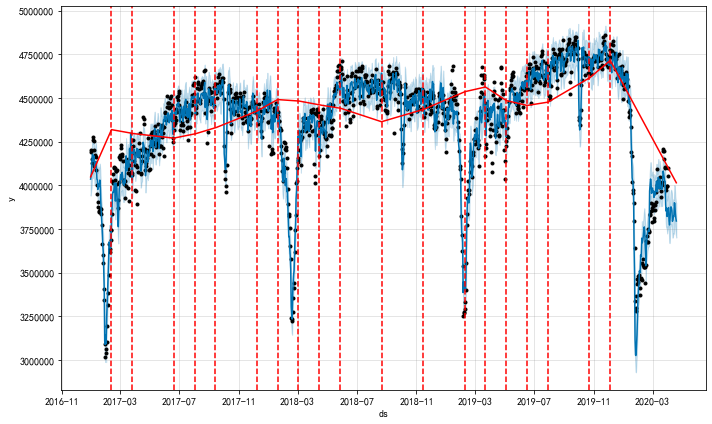

In [58]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

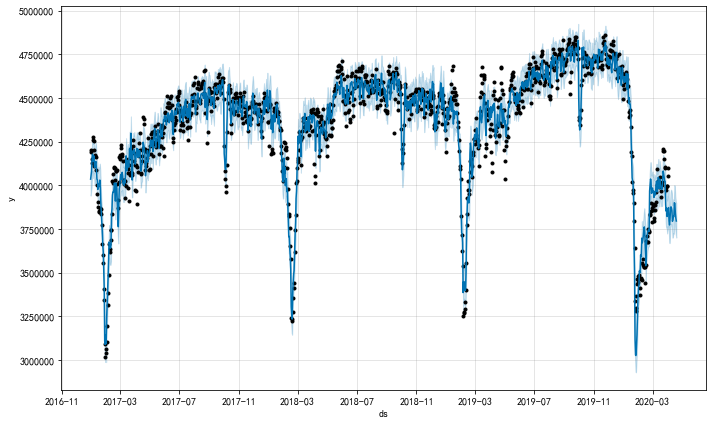

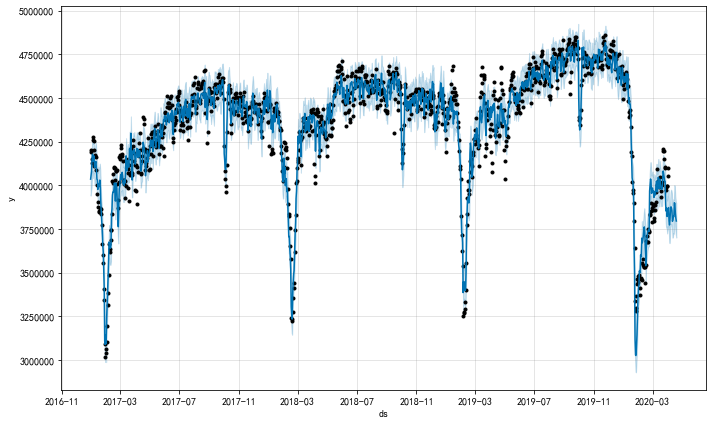

In [59]:
m.plot(forecast)

In [ ]:
m.plot(forecast)
m.plot_components(forecast)

In [ ]:
yhat=np.array(m.predict(test)['yhat'])
y=np.array(test['y'])
print(np.mean(np.abs((y-yhat)/y))) 
print(np.sqrt(np.sum((y-yhat)**2)/len(y)) )

In [ ]:
forecast[['ds', 'yhat']]

In [ ]:
x=np.linspace(1, 20, 1000)
plt.scatter(x,(1*np.sin(6.18/7*x)+1*np.cos(6.18/7*x)))



In [ ]:
dd